# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing.


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
# pip install --upgrade scipy --user

In [6]:
# Import necessary functions

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.metrics import mean_squared_error

from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report

from numpy import mean
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

sns.set(font_scale = 1)

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
df = pd.read_csv('data/zillow_data.csv')

In [ ]:
df.shape

# Step 2: Data Preprocessing

In [ ]:
melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
melted = melted.dropna(subset=['value'])

In [ ]:
melted

In [ ]:
melted = melted.rename(columns={'RegionName': 'ZipCode'})

In [ ]:
melted = melted.drop('RegionID', axis=1)

In [ ]:
melted

In [ ]:
melted.set_index('time', inplace=True)

In [ ]:
melted['ZipCode'] = melted['ZipCode'].map("{:05}".format)

In [ ]:
melted

# Step 3: EDA and Visualization

In [ ]:
# font = {'family' : 'normal',
        # 'weight' : 'bold',
        # 'size'   : 22}

# plt.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [ ]:
melted_states = melted.groupby('State').mean()
melted_states.reset_index(drop=False, inplace=True)

In [ ]:
melted_states.sort_values(by='value', ascending=False).head(10)

In [ ]:
import plotly.express as px

fig = px.choropleth(melted_states,
                    locations='State', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='value',
                    color_continuous_scale="Viridis_r",      
                    )
fig.update_layout(
      title_text = 'Mean Home Value by State, 1996 - 2018',
      title_font_family="Arial",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45, 
         )
fig.show()

In [ ]:
df_top_zip = melted[(melted['ZipCode'] == '80216') |
                    (melted['ZipCode'] == '94601') |
                    (melted['ZipCode'] == '48240') |
                    (melted['ZipCode'] == '94590') |
                    (melted['ZipCode'] == '33705')]

In [ ]:
df_top_zip

In [3]:
plt.figure(figsize=(12,8))
for zipcode in df_top_zip.ZipCode.unique():
    df_top_zip.loc[df_top_zip['ZipCode'] == zipcode].value.plot(label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.show();

NameError: name 'df_top_zip' is not defined

<Figure size 864x576 with 0 Axes>

In [19]:
df_94590 = melted[melted['ZipCode'] == '94590']

In [20]:
df_94590 = df_94590['value']
df_94590

time
1996-04-01    108200.0
1996-05-01    107800.0
1996-06-01    107500.0
1996-07-01    107300.0
1996-08-01    107100.0
                ...   
2017-12-01    357100.0
2018-01-01    362500.0
2018-02-01    366900.0
2018-03-01    371600.0
2018-04-01    376100.0
Name: value, Length: 265, dtype: float64

In [21]:
type(df_94590)

pandas.core.series.Series

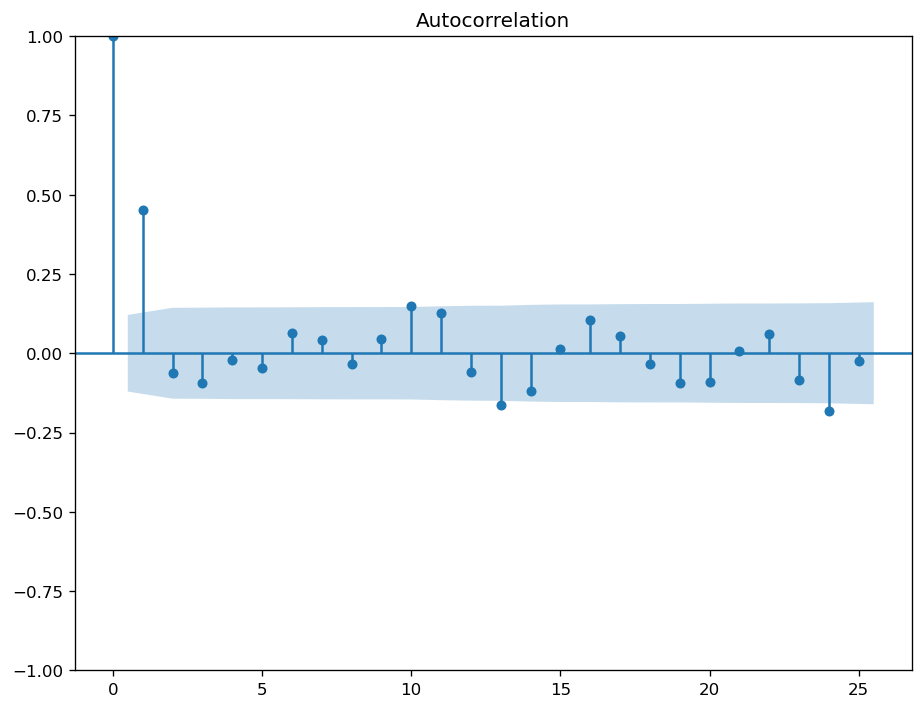

In [29]:
plot_acf(df_94590.diff().diff().dropna());

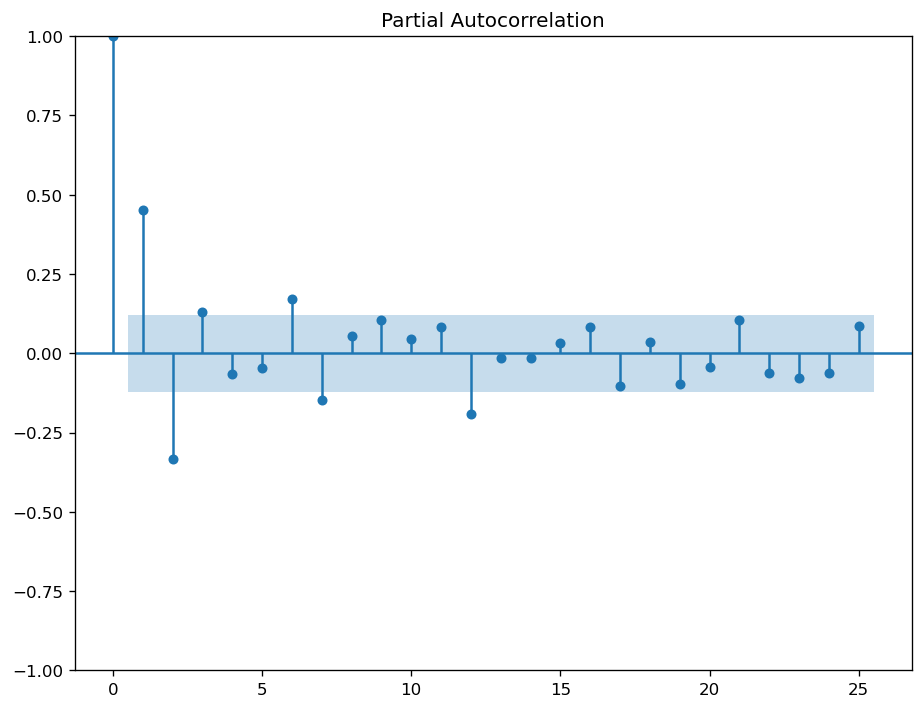

In [31]:
plot_pacf(df_94590.diff().diff().dropna(), method='ywm');

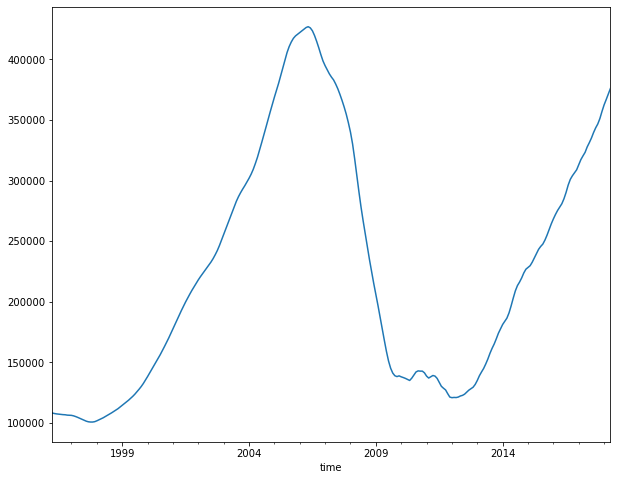

In [22]:
plt.figure(figsize=(10,8))
df_94590.plot()
plt.show()

In [23]:
plt.figure(figsize=(12,8))
autocorrelation_plot(df_94590)
plt.show()

NameError: name 'autocorrelation_plot' is not defined

<Figure size 864x576 with 0 Axes>

In [33]:
df_ddiff = df_94590.diff().diff().dropna()

In [32]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(df_94590)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.628365
p-value: 0.087275


In [34]:
result = adfuller(df_ddiff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.439240
p-value: 0.000253


In [39]:
cutoff = '2013-05'
train = df_ddiff[:cutoff]
test = df_ddiff[cutoff:]

In [40]:
from statsmodels.tsa.arima.model import ARIMA

ar_1 = ARIMA(train, order=(1, 0, 1)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
train_pred = ar_1.predict()

C:\Users\pschu\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\pschu\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\pschu\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [41]:
from sklearn.metrics import mean_squared_error
import numpy as np

np.sqrt(mean_squared_error(train, train_pred))

590.2555357787061

In [42]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1591.343
Date:                Tue, 28 Mar 2023   AIC                           3190.685
Time:                        10:35:28   BIC                           3203.958
Sample:                    06-01-1996   HQIC                          3196.054
                         - 05-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.0981     82.302      0.244      0.807    -141.211     181.407
ar.L1          0.2624      0.075      3.511      0.000       0.116       0.409
ma.L1          0.4348      0.074      5.891      0.000       0.290       0.579
sigma2      3.496e+05   2.13e+04     16.401      0.000    3.08e+05    3.91e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                95.67
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):              44.60   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
ar_2 = ARIMA(train, order=(1, 0, 2)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
train_pred = ar_2.predict()

C:\Users\pschu\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\pschu\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\pschu\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [45]:
np.sqrt(mean_squared_error(train, train_pred))

552.2361654953825

In [44]:
ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1578.421
Date:                Tue, 28 Mar 2023   AIC                           3166.841
Time:                        10:36:06   BIC                           3183.432
Sample:                    06-01-1996   HQIC                          3173.553
                         - 05-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.5601     81.331      0.253      0.800    -138.846     179.966
ar.L1         -0.6175      0.054    -11.492      0.000      -0.723      -0.512
ma.L1          1.5011      0.043     34.942      0.000       1.417       1.585
ma.L2          0.8192      0.036     22.711      0.000       0.748       0.890
sigma2      3.048e+05   2.07e+04     14.710      0.000    2.64e+05    3.45e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):                64.94
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):              26.46   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
y_pred = ar_2.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ar_2.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

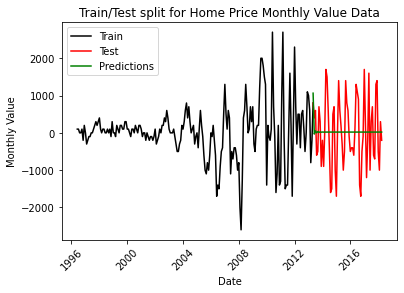

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train, color = "black",label='Train')
plt.plot(test, color = "red",label='Test')
plt.ylabel('Monthly Value')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Home Price Monthly Value Data")
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend();

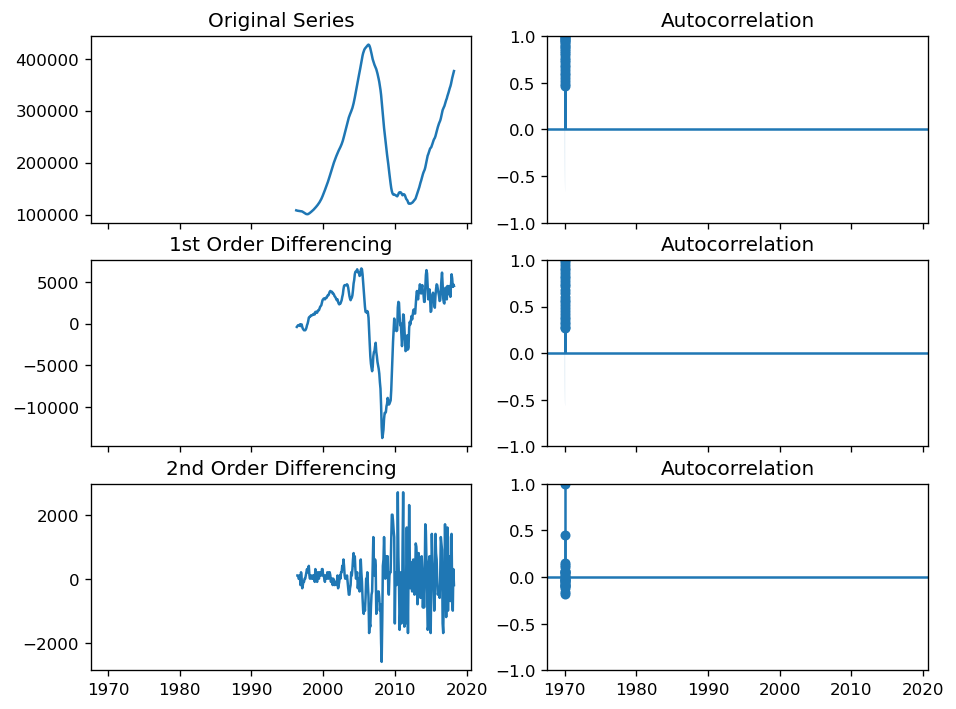

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df_94590); axes[0, 0].set_title('Original Series')
plot_acf(df_94590, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_94590.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_94590.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_94590.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_94590.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [ ]:
df = pd.read_csv('data/zillow_data.csv')

In [ ]:
df['five_year'] = ((df['2018-04'] - df['2013-04']) / df['2013-04']) * 100
df['ten_year'] = ((df['2018-04'] - df['2008-04']) / df['2008-04']) * 100
df['fifteen_year'] = ((df['2018-04'] - df['2003-04']) / df['2003-04']) * 100

In [ ]:
df.sort_values(by='five_year', ascending=False).head(10)

# Step 5: ARIMA Modeling

# Step 6: Interpreting Results